# 数据类别不均衡处理

在可视化环节中，我们观察到正负样本的比例大概在1:3左右，因此需要对正样本进行升采样或对负样本进行降采样。考虑到本数据集仅有7千多条样本，不适合采用降采样，进行升采样更为合理，本案例采用升采样中较为成熟的SMOTE方法生成更多的正样本。


# 补充知识：SMOTE方法


SMOTE（Synthetic Minority Oversampling Technique），合成少数类过采样技术．它是基于随机过采样算法的一种改进方案，由于随机过采样采取简单复制样本的策略来增加少数类样本，这样容易产生模型过拟合的问题，即使得模型学习到的信息过于特别(Specific)而不够泛化(General)，SMOTE算法的基本思想是对少数类样本进行分析并根据少数类样本人工合成新样本添加到数据集中，具体如下图所示，算法流程如下。

<ol>
    <li>对于少数类中每一个样本x，以欧氏距离为标准计算它到少数类样本集中所有样本的距离，得到其k近邻。</li>
<li>根据样本不平衡比例设置一个采样比例以确定采样倍率N，对于每一个少数类样本x，从其k近邻中随机选择若干个样本，假设选择的近邻为xn。</li>
<li>对于每一个随机选出的近邻xn，分别与原样本按照如下的公式构建新的样本。</li>
</ol>

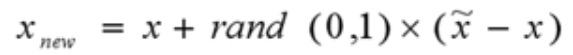

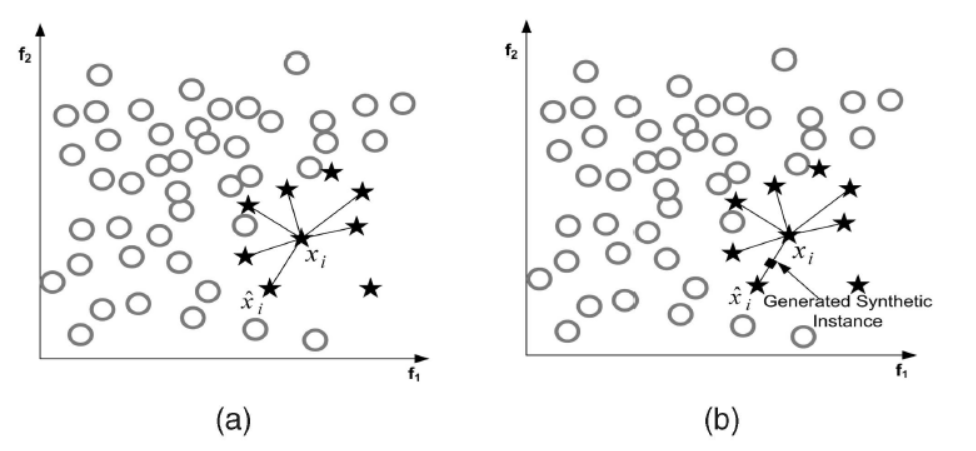


In [1]:
import time 
import random
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors    # k近邻算法

In [2]:
# 设置忽略警告
import warnings
warnings.filterwarnings('ignore')

#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)

### 设置不使用科学计数法  #为了直观的显示数字，不采用科学计数法
np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# 加载前面处理好的数据
data = pd.read_csv("./processed_data/processed_data.csv")
print(data.shape)
print(data["Churn"].value_counts())
data.head()

(7043, 22)
Churn
0    5174
1    1869
Name: count, dtype: int64


,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,MonthlyCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,1,0,-1.28,0,0,1,0,0,1,-1.16,True,False,False,True,False,False,False,False,True,False,0
1,0,0,0,0.07,0,1,0,1,0,0,-0.26,True,False,False,False,True,False,False,False,False,True,0
2,0,0,0,-1.24,0,1,1,0,0,1,-0.36,True,False,False,True,False,False,False,False,False,True,1
3,0,0,0,0.51,0,1,0,1,1,0,-0.75,True,False,False,False,True,False,True,False,False,False,0
4,0,0,0,-1.24,0,0,0,0,0,1,0.20,False,True,False,True,False,False,False,False,True,False,1


In [4]:
# 定义Smote类
class Smote:
    def __init__(self,samples,N,k):#samples是少数类别的样本的特征
        self.n_samples,self.n_attrs=samples.shape
        self.N=N  #采样的倍率
        self.k=k
        self.samples=samples
        self.newindex=0

    def over_sampling(self):
        N=int(self.N)
        self.synthetic = np.zeros((self.n_samples * N, self.n_attrs))#用于存放新合成的样本
        neighbors=NearestNeighbors(n_neighbors=self.k).fit(self.samples) # 建KDtree   
        for i in range(len(self.samples)):# 对每个少数类样本均求其在所有少数类样本中的k近邻
            nnarray=neighbors.kneighbors(self.samples[i].reshape(1,-1),return_distance=False)[0]
            self._populate(N,i,nnarray)
        return self.synthetic

    # 为每个少数类样本选择k个最近邻中的N个,并生成N个合成样本
    def _populate(self,N,i,nnarray):
        for j in range(N):
            nn=random.randint(0,self.k-1)
            dif=self.samples[nnarray[nn]]-self.samples[i]
            gap=random.random()
            self.synthetic[self.newindex]=self.samples[i]+gap*dif
            self.newindex+=1

In [5]:
# 每个正样本用SMOTE方法随机生成两个新的样本
posDf = data[data['Churn'] == 1].drop(['Churn'], axis=1)    # 共1869条正样本, 取其所有特征列(删除标签列)
posArray = posDf.values    # pd.DataFrame -> np.array, 以满足SMOTE方法的输入要求
newPosArray = Smote(posArray, 2, 5).over_sampling()
newPosDf = pd.DataFrame(newPosArray)    # np.array -> pd.DataFrame
print(newPosDf.shape)

(3738, 21)


In [6]:
newPosDf.head(10)  # 观察此时的新样本：1.列名，2.离散数据(应该只有0和1，不会出现小数)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.00,0.00,0.00,-1.23,0.00,0.72,1.00,0.00,0.00,1.00,-0.40,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
1,0.00,0.00,0.00,-1.16,0.00,0.38,1.00,0.00,0.00,1.00,-0.42,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2,0.00,0.00,0.00,-1.27,0.00,0.00,0.00,0.00,0.00,1.00,0.20,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
3,0.00,0.00,0.00,-1.24,0.00,0.00,0.00,0.00,0.00,1.00,0.20,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0.00,0.00,0.00,-0.99,1.00,0.00,0.00,1.00,0.00,1.00,1.16,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
5,0.00,0.00,0.00,-0.99,1.00,0.00,0.00,1.00,0.00,1.00,1.16,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
6,0.00,1.00,0.12,-0.16,1.00,0.00,0.00,1.00,1.00,1.00,1.33,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
7,0.00,1.00,0.00,0.35,1.00,0.00,0.00,1.00,1.00,1.00,0.70,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
8,0.56,0.00,0.00,0.52,1.00,0.00,1.00,1.00,0.00,1.00,1.31,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.68,1.00,0.00,1.00,1.00,0.00,1.00,1.29,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00


In [7]:
newPosDf.tail(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
3728,0.00,0.00,0.00,-0.83,0.00,0.00,0.00,0.00,1.00,1.00,-0.16,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
3729,0.00,0.00,0.00,-1.11,0.00,0.00,0.00,0.00,1.00,1.00,0.08,1.00,0.00,0.00,0.77,0.23,0.00,0.00,0.00,1.00,0.00
3730,0.00,0.00,0.00,-0.88,0.00,0.00,0.00,0.00,0.00,1.00,-0.66,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
3731,0.00,0.00,0.00,-1.24,0.00,0.00,0.00,0.00,0.00,1.00,-0.66,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
3732,1.00,0.00,0.00,-1.28,1.00,0.00,0.00,0.00,0.00,1.00,0.36,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
3733,1.00,0.00,0.00,-1.28,1.00,0.00,0.00,0.00,0.00,1.00,0.39,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
3734,0.00,0.00,0.00,1.41,1.00,1.00,1.00,1.00,0.00,1.00,1.27,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
3735,0.00,0.00,0.00,1.28,1.00,0.88,1.00,1.00,0.00,1.00,1.28,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
3736,1.00,1.00,0.00,-1.06,1.00,0.00,0.00,0.00,0.00,1.00,0.32,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
3737,1.00,0.40,0.00,-1.20,1.00,0.00,0.00,0.00,0.00,1.00,0.34,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


In [8]:
# 调整为正样本在数据集中应有的格式
newPosDf.columns = posDf.columns    # 还原特征名
cateCols = list(newPosDf.columns.drop(['tenure', 'MonthlyCharges']))   # 提取离散特征名组成的列表
for i in cateCols:
    newPosDf[i] = newPosDf[i].apply(lambda x: 1 if x >= 0.5 else 0)    # 将特征值变回0、1二元数值  由于二类别的数据的值都是1或者0，多类别的数据已经做了one-hot处理，所以这种方法可行
newPosDf['Churn'] = 1    # 添加目标变量列
print(newPosDf.shape)
newPosDf.head(10)    # 观察此时的新样本

(3738, 22)


,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,MonthlyCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,0,0,-1.23,0,1,1,0,0,1,-0.40,1,0,0,1,0,0,0,0,0,1,1
1,0,0,0,-1.16,0,0,1,0,0,1,-0.42,1,0,0,1,0,0,0,0,0,1,1
2,0,0,0,-1.27,0,0,0,0,0,1,0.20,0,1,0,1,0,0,0,0,1,0,1
3,0,0,0,-1.24,0,0,0,0,0,1,0.20,0,1,0,1,0,0,0,0,1,0,1
4,0,0,0,-0.99,1,0,0,1,0,1,1.16,0,1,0,1,0,0,0,0,1,0,1
5,0,0,0,-0.99,1,0,0,1,0,1,1.16,0,1,0,1,0,0,0,0,1,0,1
6,0,1,0,-0.16,1,0,0,1,1,1,1.33,0,1,0,1,0,0,0,0,1,0,1
7,0,1,0,0.35,1,0,0,1,1,1,0.70,0,1,0,1,0,0,0,0,1,0,1
8,1,0,0,0.52,1,0,1,1,0,1,1.31,0,1,0,1,0,0,1,0,0,0,1
9,0,0,0,0.68,1,0,1,1,0,1,1.29,0,1,0,1,0,0,1,0,0,0,1


In [9]:
print("原本的正样本有%d条" % posDf.shape[0])
print("原本的负样本有%d条" % (data.shape[0] - posDf.shape[0]))

原本的正样本有1869条
原本的负样本有5174条


In [10]:
# 为保证正负样本平衡，从新生成的样本中取出（5174 - 1869 = 3305）条样本，并加入原数据集进行shuffle操作。也完全可以不做这个操作

# 构建类别平衡的数据集
from sklearn.utils import shuffle    

# newPosDf = newPosDf[:3305]    # 直接选取前3305条样本
newPosDf = newPosDf.sample(n=3305) # 随机抽取3305条样本
data = pd.concat([data, newPosDf])    # 竖向拼接
data = shuffle(data).reset_index(drop=True) # 样本打乱
print(data["Churn"].value_counts())
print("此时数据集的规模为：", data.shape)
data.to_csv("./processed_data/processed_smote.csv",index=False)
data.head()

Churn
0    5174
1    5174
Name: count, dtype: int64
此时数据集的规模为： (10348, 22)


,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,MonthlyCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,1,1,0.03,1,0,0,0,0,0,-1.35,0,0,1,1,0,0,1,0,0,0,0
1,0,0,0,-1.28,0,0,0,0,0,1,-0.65,1,0,0,1,0,0,1,0,0,0,1
2,0,0,0,-1.28,0,0,0,0,0,0,-1.49,0,0,1,1,0,0,0,0,0,1,1
3,0,1,1,1.41,1,0,0,1,1,1,0.17,1,0,0,0,0,1,1,0,0,0,0
4,0,1,0,1.61,1,1,1,1,1,1,0.88,1,0,0,0,0,1,1,0,0,0,0


# 模型选型与训练

- 我们使用逻辑回归、SVC、随机森林、LightBGM，然后从中选择最优的


In [17]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC as SVC
from sklearn.ensemble import RandomForestClassifier as RF
from lightgbm import LGBMClassifier as LGB  # pip install lightGBM

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

- K折交叉验证，这里可以获得预测结果，后面用于评估模型的性能，从而选择最佳的模型

In [18]:
def kFold_cv(X, y, classifier, **kwargs):
    """
    :param X: 特征
    :param y: 目标变量
    :param classifier: 分类器
    :param **kwargs: 参数
    :return: 预测结果
    """
    kf = KFold(n_splits=5, shuffle=True) # 5折交叉验证
    y_pred = np.zeros(len(y))    # 初始化y_pred数组
    start = time.time()
    for train_index, test_index in kf.split(X):  #kf.split得到5组训练集和测试集
        X_train = X[train_index]    
        X_test = X[test_index]
        y_train = y[train_index]    # 划分数据集
        clf = classifier(**kwargs)    
        clf.fit(X_train, y_train)    # 模型训练
        y_pred[test_index] = clf.predict(X_test)    # 模型预测
    print("used time : {}".format(time.time()-start))
    return y_pred  

In [19]:
# 获取X,Y
# 加载数据
data = pd.read_csv("./processed_data/processed_smote.csv")
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]
print(X.shape)
print(Y.shape)
print(data.head())


(10348, 21)
(10348,)
   SeniorCitizen  Partner  Dependents  tenure  MultipleLines  OnlineSecurity  \
0              0        1           1    0.03              1               0   
1              0        0           0   -1.28              0               0   
2              0        0           0   -1.28              0               0   
3              0        1           1    1.41              1               0   
4              0        1           0    1.61              1               1   

   OnlineBackup  DeviceProtection  TechSupport  PaperlessBilling  \
0             0                 0            0                 0   
1             0                 0            0                 1   
2             0                 0            0                 0   
3             0                 1            1                 1   
4             1                 1            1                 1   

   MonthlyCharges  InternetService_DSL  InternetService_Fiber optic  \
0           -1.35 

In [20]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8278, 21)
(2070, 21)
(8278,)
(2070,)


In [25]:
# 这里仅作演示的baseline，参数没仔细调，这里大家可以调完参数选择最优化模型进行训练/或者进行模型融合，再进行预测
# 进行K折交叉验证
lr_pred = kFold_cv(x_train.values,y_train.values,LR,penalty='l2',C=1.0)
svc_pred = kFold_cv(x_train.values,y_train.values,SVC,C=1.0)
rf_pred = kFold_cv(x_train.values,y_train.values, RF,n_estimators=100,max_depth=10)
lgb_pred = kFold_cv(x_train.values,y_train.values,LGB,learning_rate=0.1,n_estimators=1000,max_depth=10)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3288, number of negative: 3334
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 6622, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496527 -> initscore=-0.013893
[LightGBM] [Info] Start training from score -0.013893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3303, number of negative: 3320
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.

In [26]:
scoreDf = pd.DataFrame(columns=['LR', 'SVC', 'RandomForest', 'LGB'])
pred = [lr_pred, svc_pred, rf_pred, lgb_pred]
for i in range(len(pred)):
    r = recall_score(y_train.values, pred[i])
    p = precision_score(y_train.values, pred[i])
    f1 = f1_score(y_train.values, pred[i])
    scoreDf.iloc[:, i] = pd.Series([r, p, f1])

scoreDf.index = ['Recall', 'Precision', 'F1-score']
scoreDf

,LR,SVC,RandomForest,LGB
Recall,0.80,0.81,0.87,0.86
Precision,0.75,0.75,0.78,0.81
F1-score,0.77,0.78,0.82,0.83


由上表可知，LGB模型效果最好，我们选择LGB模型单模型进行演示，并且输出其特征重要性

In [27]:
lgb = LGB(learning_rate=0.1,n_estimators=1000,max_depth=10)
lgb.fit(x_train,y_train)
y_train_pred = lgb.predict(x_train)
y_test_pred = lgb.predict(x_test)
print(classification_report(y_train,y_train_pred))
print(classification_report(y_test,y_test_pred))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4118, number of negative: 4160
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497463 -> initscore=-0.010147
[LightGBM] [Info] Start training from score -0.010147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [28]:
# 特征重要度，树模型都有特征重要度
feature_importances = lgb.feature_importances_
feature_importances

array([  642,  1013,   683,  9530,   617,   654,   728,   787,   531,
         792, 10725,   138,   127,    27,   284,   351,   181,   461,
         400,   920,   381])

In [29]:
featurs_import_df = pd.DataFrame(X.columns,columns=['feature'])
featurs_import_df['importance'] = feature_importances
featurs_import_df

,feature,importance
0,SeniorCitizen,642
1,Partner,1013
2,Dependents,683
3,tenure,9530
4,MultipleLines,617
5,OnlineSecurity,654
6,OnlineBackup,728
7,DeviceProtection,787
8,TechSupport,531
9,PaperlessBilling,792


In [30]:
import matplotlib.pyplot as plt
import lightgbm 

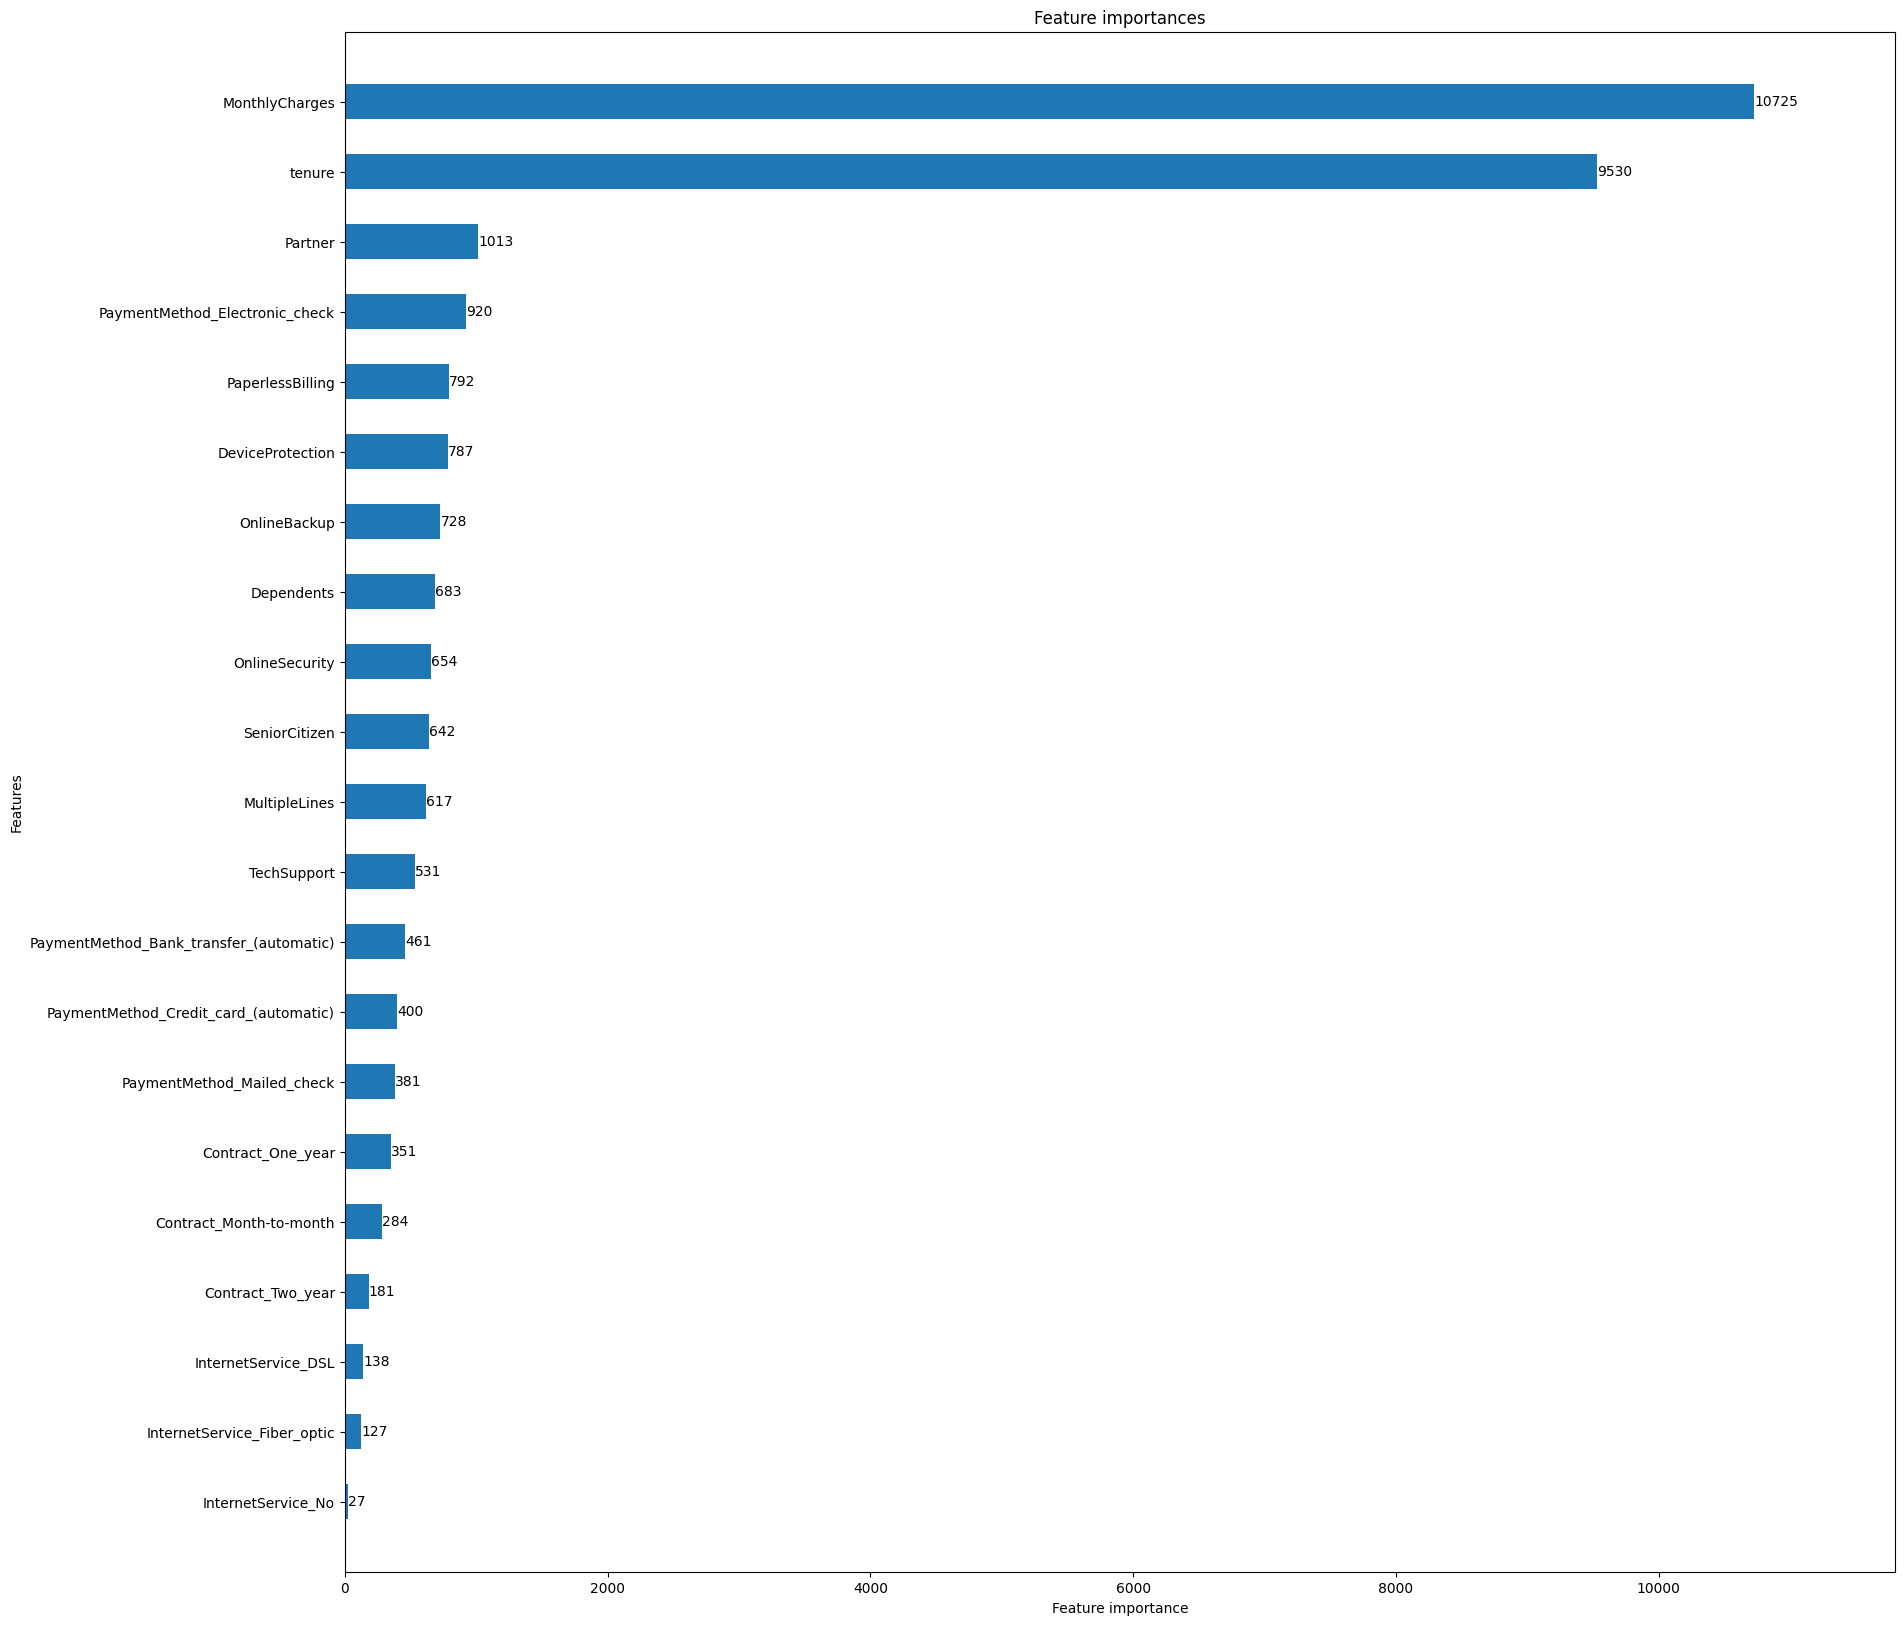

In [31]:
fig, ax = plt.subplots(figsize=(20,20))
lightgbm.plot_importance(lgb,ax=ax,height=0.5,grid=False)
plt.title("Feature importances")
plt.show()



In [32]:
# 训练好后对模型进行存储
import joblib
joblib.dump(lgb,"./models/lgb.m")
# joblib.load()

['./models/lgb.m']

# 分析与决策

## 在可视化阶段，可以发现较易流失的客户在各个特征的用户画像如下：

- 基本信息
- - 老年人
- - 未婚
- - 无家属
- - 入网时间不长，特别是2个月之内


- 开通业务
- - 开通光纤网络
- - 未开通在线安全、在线备份、设备保护、技术支持等互联网增值业务


- 签订合约
- - 合约期限较短，特别是逐月付费客户最易流失
- - 采用电子结算（多为按月支付）
- - 采用电子支票
- - 每月费用较高，特别是70～110之间
- - 总费用较低（侧面反应入网时间较短）



## 根据用户画像，可以从各个方面推出相应活动以求留下可能流失的客户：

- - 对老人推出亲情套餐等优惠
- - 对未婚、无家属的客户推出暖心套餐等优惠
- - 对新入网用户提供一定时期的优惠活动，直至客户到达稳定期
- - 提高电话服务、光纤网络、网络电视、网络电影等的客户体验，尝试提高用户的留存率，避免客户流失
- - 对能够帮助客户留存的在线安全、在线备份、设备保护、技术支持等互联网增值业务，加大宣传推广力度
- - 对逐月付费用户推出年费优惠活动
- - 对使用电子结算、电子支票的客户，推出其他支付方式的优惠活动
- - 对每月费用在70～110之间推出一定的优惠活动

## 在模型预测阶段，可以结合预测出的概率值决定对哪些客户进行重点留存：

In [33]:
# 加载前面处理好的数据
data = pd.read_csv("./processed_data/processed_data.csv")
print(data.shape)
print(data["Churn"].value_counts())
data.head()

(7043, 22)
Churn
0    5174
1    1869
Name: count, dtype: int64


,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,MonthlyCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,1,0,-1.28,0,0,1,0,0,1,-1.16,True,False,False,True,False,False,False,False,True,False,0
1,0,0,0,0.07,0,1,0,1,0,0,-0.26,True,False,False,False,True,False,False,False,False,True,0
2,0,0,0,-1.24,0,1,1,0,0,1,-0.36,True,False,False,True,False,False,False,False,False,True,1
3,0,0,0,0.51,0,1,0,1,1,0,-0.75,True,False,False,False,True,False,True,False,False,False,0
4,0,0,0,-1.24,0,0,0,0,0,1,0.20,False,True,False,True,False,False,False,False,True,False,1


In [34]:
X,Y = data.iloc[:,:-1],data.iloc[:,-1]
pred_prob = lgb.predict_proba(X)
pred_prob = np.round(pred_prob, 1) # 对预测出的概率值保留两位小数，便于分组观察
print(pred_prob[:5])
print(Y[:5])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[[0.2 0.8]
 [1.  0. ]
 [0.5 0.5]
 [1.  0. ]
 [0.1 0.9]]
0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64


In [35]:
# 合并预测值和真实值
probDf = pd.DataFrame(pred_prob)
churnDf = pd.DataFrame(Y)
df1 = pd.concat([probDf, churnDf], axis=1)
df1.columns = ['prob_0','prob_1', 'churn']
df1.head(10)

,prob_0,prob_1,churn
0,0.20,0.80,0
1,1.00,0.00,0
2,0.50,0.50,1
3,1.00,0.00,0
4,0.10,0.90,1
5,0.00,1.00,1
6,0.80,0.20,0
7,1.00,0.00,0
8,0.00,1.00,1
9,1.00,0.00,0


In [36]:
# 分组计算每种预测概率值所对应的真实流失率
df1.drop("prob_0",inplace=True,axis=1)
group = df1.groupby(['prob_1'])
cnt = group.count()    # 每种概率值对应的样本数
true_prob = group.sum() / group.count()    # 真实流失率
df2 = pd.concat([cnt,true_prob], axis=1).reset_index()
df2.columns = ['prob_1', 'cnt', 'true_prob']
df2

,prob_1,cnt,true_prob
0,0.00,3464,0.01
1,0.10,767,0.02
2,0.20,362,0.03
3,0.30,186,0.08
4,0.40,147,0.16
5,0.50,120,0.26
6,0.60,147,0.48
7,0.70,143,0.64
8,0.80,310,0.85
9,0.90,779,0.92


由表可知：预测流失率越大的客户中越有可能真正发生流失。对运营商而言，可以根据各预测概率值分组的真实流失率设定阈值进行决策。例如，假设阈值为true_prob = 0.5，即优先关注真正流失为50%以上的群体，也就表示运营商可以对预测结果中大于等于0.6的客户进行重点留存。

In [ ]:
# todo:
